# Загрузите данные и выберите временные ряды


Отображение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/skab_valve_1.csv', sep=';')

print(df.head())
print(df.columns)

              datetime  Accelerometer1RMS  Accelerometer2RMS  Current  \
0  2020-03-09 12:34:37           0.028030           0.040400  1.18285   
1  2020-03-09 12:34:38           0.026952           0.038880  1.45268   
2  2020-03-09 12:34:39           0.027958           0.040660  1.02300   
3  2020-03-09 12:34:40           0.027277           0.040736  1.22751   
4  2020-03-09 12:34:41           0.027210           0.039489  1.21526   

   Pressure  Temperature  Thermocouple  Voltage  Volume Flow RateRMS  anomaly  \
0  0.054711      69.9219       24.9122  229.918              32.9875      0.0   
1 -0.273216      69.9147       24.9038  219.566              32.0129      0.0   
2  0.054711      69.8861       24.9055  237.717              32.9875      0.0   
3 -0.273216      69.8397       24.9110  227.621              32.0000      0.0   
4 -0.273216      69.9136       24.9110  221.634              32.0129      0.0   

   changepoint  
0          0.0  
1          0.0  
2          0.0  
3     

Выберите столбец «Термопара»


In [2]:
series = df['Thermocouple']


Построить временной ряд термопары


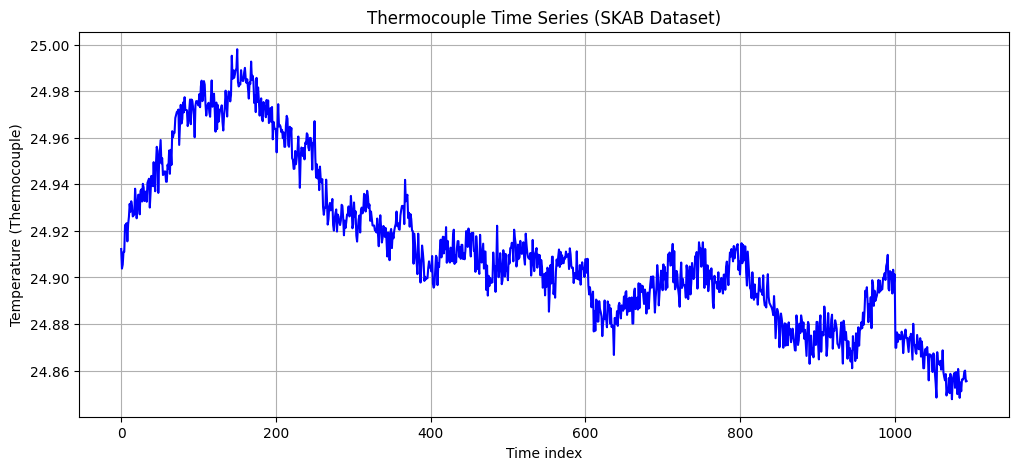

In [3]:
plt.figure(figsize=(12,5))
plt.plot(series, color='blue')
plt.title('Thermocouple Time Series (SKAB Dataset)')
plt.xlabel('Time index')
plt.ylabel('Temperature (Thermocouple)')
plt.grid(True)
plt.show()

# Разделение на обучающую и тестовую выборки + выбор метрики

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

Мы используем 80% для обучения и 20% для тестирования.

In [5]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

Показываем длины деталей

In [6]:
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 875, Test size: 219


Мы рисуем их вместе

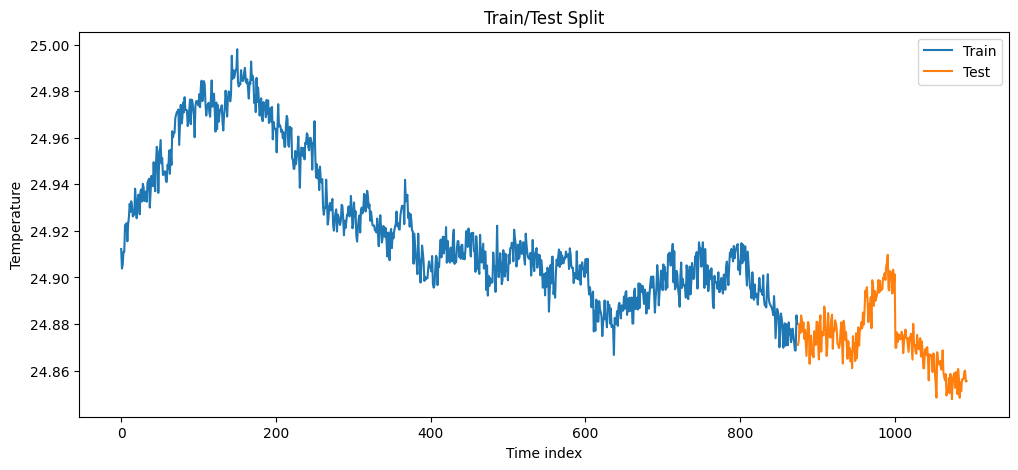

In [7]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(range(train_size, len(series)), test, label='Test')
plt.title('Train/Test Split')
plt.xlabel('Time index')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Базовая модель (наивный прогноз/скользящее среднее)

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error

Базовый уровень 1: Наивный прогноз, Спрогнозируйте последнее значение поезда для каждой точки теста.

In [9]:
naive_forecast = np.repeat(train.iloc[-1], len(test))

Базовый уровень 2: скользящая средняя

In [10]:
window = 10
moving_avg_forecast = train.rolling(window=window).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_forecast, len(test))

Оценка моделей с использованием MAE

In [11]:
mae_naive = mean_absolute_error(test, naive_forecast)
mae_ma = mean_absolute_error(test, moving_avg_forecast)

print(f"Naive Forecast MAE: {mae_naive:.4f}")
print(f"Moving Average MAE: {mae_ma:.4f}")

Naive Forecast MAE: 0.0121
Moving Average MAE: 0.0104


Результаты жеребьевки

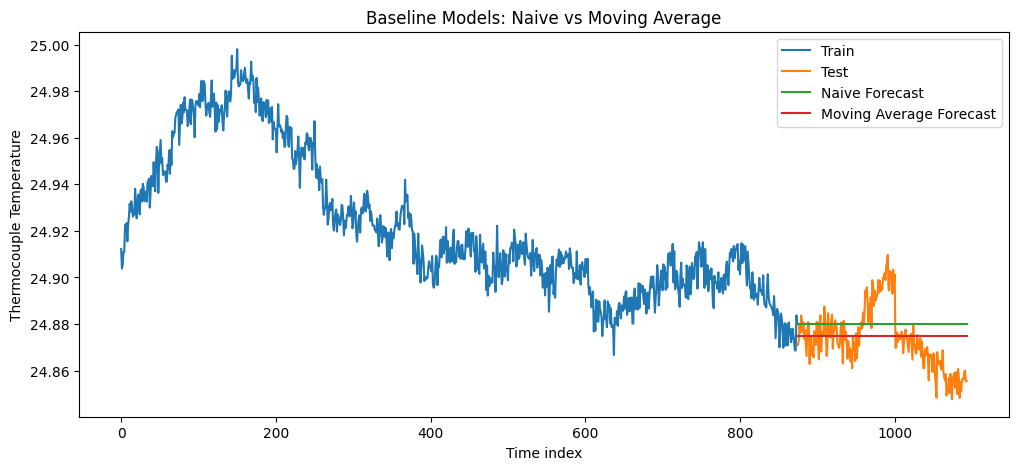

In [12]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, naive_forecast, label='Naive Forecast')
plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast')
plt.title('Baseline Models: Naive vs Moving Average')
plt.xlabel('Time index')
plt.ylabel('Thermocouple Temperature')
plt.legend()
plt.show()

# Проверка стационарности (Test Dickey-Fuller + ACF/PACF)

Расширенный тест Дики-Фуллера

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print(" Ряд стационарный (p-value ≤ 0.05)")
else:
    print(" Ряд нестационарный (p-value > 0.05)")


ADF Statistic: -0.4518353967152232
p-value: 0.901077784796549
 Ряд нестационарный (p-value > 0.05)


Нарисуйте ACF и PACF

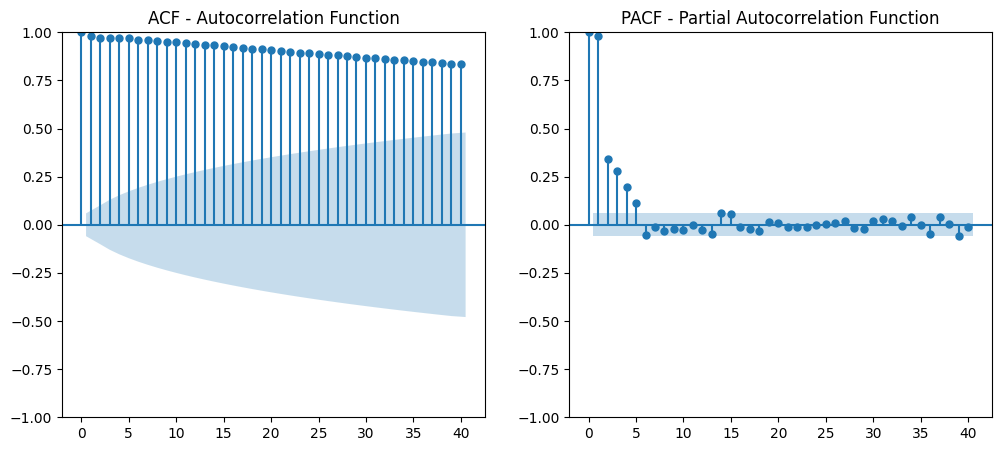

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(series.dropna(), lags=40, ax=plt.gca())
plt.title('ACF - Autocorrelation Function')

plt.subplot(1,2,2)
plot_pacf(series.dropna(), lags=40, ax=plt.gca())
plt.title('PACF - Partial Autocorrelation Function')
plt.show()

# Вычисление дифференциации строки

Первая командная работа

In [15]:
diff_series = series.diff().dropna()

Тест Дики-Фуллера после разности


In [16]:
result_diff = adfuller(diff_series)
print('ADF Statistic (after differencing):', result_diff[0])
print('p-value (after differencing):', result_diff[1])

if result_diff[1] <= 0.05:
    print(" Ряд стал стационарным (p-value ≤ 0.05)")
else:
    print(" Ряд всё ещё нестационарный (p-value > 0.05)")

ADF Statistic (after differencing): -26.879211456551285
p-value (after differencing): 0.0
 Ряд стал стационарным (p-value ≤ 0.05)


Нарисуйте ряд после разности


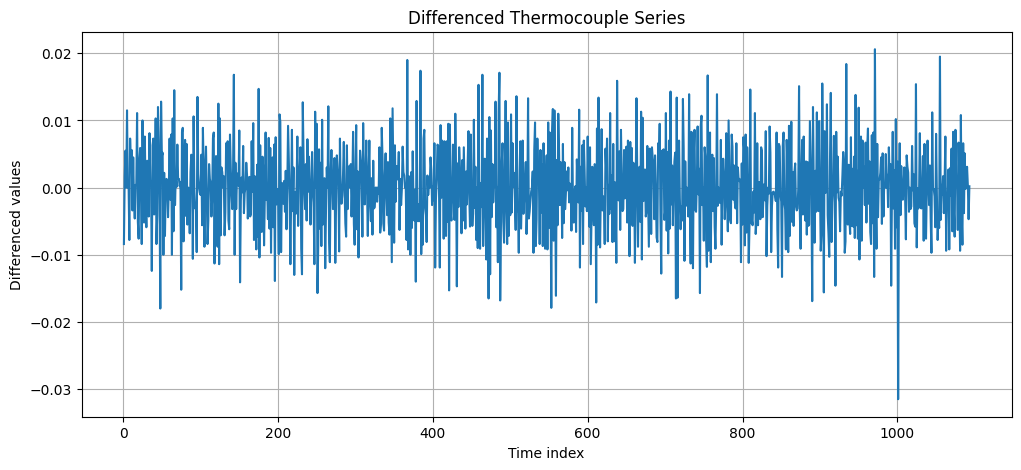

In [17]:
plt.figure(figsize=(12,5))
plt.plot(diff_series)
plt.title('Differenced Thermocouple Series')
plt.xlabel('Time index')
plt.ylabel('Differenced values')
plt.grid(True)
plt.show()

ACF и PACF построены после разности

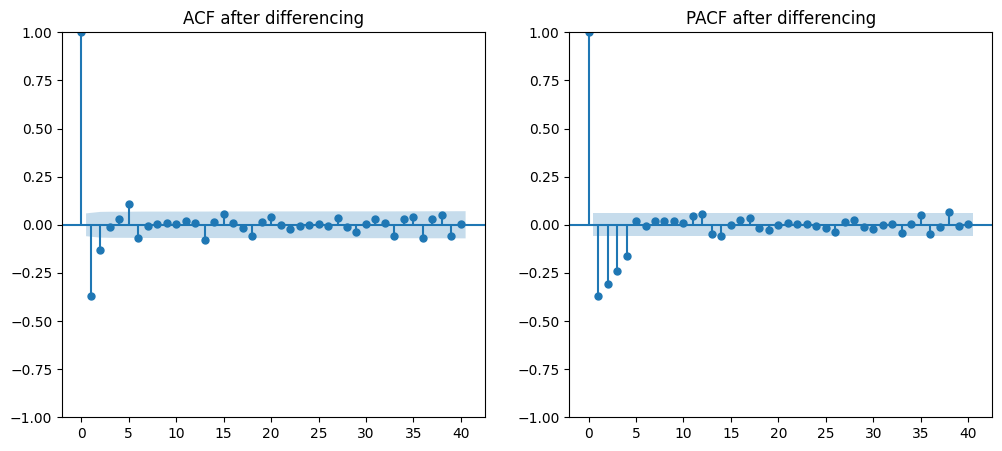

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(diff_series, lags=40, ax=plt.gca())
plt.title('ACF after differencing')

plt.subplot(1,2,2)
plot_pacf(diff_series, lags=40, ax=plt.gca())
plt.title('PACF after differencing')
plt.show()

# Модель ARIMA (авторегрессионное интегрированное скользящее среднее)

Обучение модели ARIMA

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

p, d, q = 1, 1, 1

model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))

mae_arima = mean_absolute_error(test, forecast)
print(f'ARIMA({p},{d},{q}) MAE: {mae_arima:.4f}')


                               SARIMAX Results                                
Dep. Variable:           Thermocouple   No. Observations:                  875
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3243.029
Date:                Wed, 29 Oct 2025   AIC                          -6480.058
Time:                        13:00:14   BIC                          -6465.739
Sample:                             0   HQIC                         -6474.580
                                - 875                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3075      0.047      6.610      0.000       0.216       0.399
ma.L1         -0.8652      0.016    -52.485      0.000      -0.897      -0.833
sigma2      3.496e-05   1.85e-06     18.854      0.0

Для сравнения представьте результаты на графике

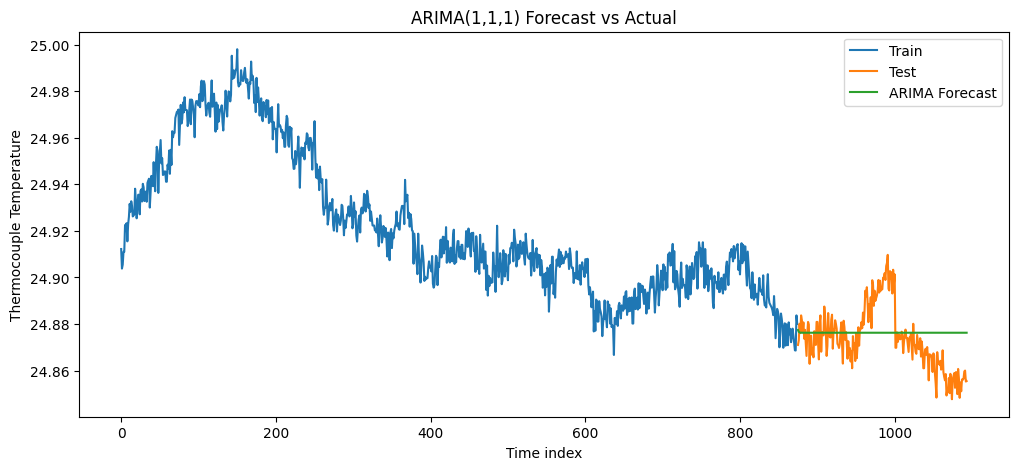

In [20]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.title(f'ARIMA({p},{d},{q}) Forecast vs Actual')
plt.xlabel('Time index')
plt.ylabel('Thermocouple Temperature')
plt.legend()
plt.show()

# Проектирование признаков + Модель случайного леса

Особенности инженерии

In [21]:
import pandas as pd

df_ml = pd.DataFrame({'y': series})

for lag in range(1, 6):
    df_ml[f'lag_{lag}'] = df_ml['y'].shift(lag)

df_ml['rolling_mean_3'] = df_ml['y'].rolling(window=3).mean()

df_ml = df_ml.dropna()

print(df_ml.head())

         y    lag_1    lag_2    lag_3    lag_4    lag_5  rolling_mean_3
5  24.9225  24.9110  24.9110  24.9055  24.9038  24.9122       24.914833
6  24.9225  24.9225  24.9110  24.9110  24.9055  24.9038       24.918667
7  24.9233  24.9225  24.9225  24.9110  24.9110  24.9055       24.922767
8  24.9155  24.9233  24.9225  24.9225  24.9110  24.9110       24.920433
9  24.9228  24.9155  24.9233  24.9225  24.9225  24.9110       24.920533


Разделение данных на обучающие и тестовые

In [22]:
train_size = int(len(df_ml) * 0.8)
train_df = df_ml.iloc[:train_size]
test_df = df_ml.iloc[train_size:]

X_train = train_df.drop('y', axis=1)
y_train = train_df['y']
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

Обучение модели случайного леса

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, rf_pred)
print(f'Random Forest MAE: {mae_rf:.4f}')

Random Forest MAE: 0.0068


Сравнительная таблица между прогнозируемыми и фактическими значениями

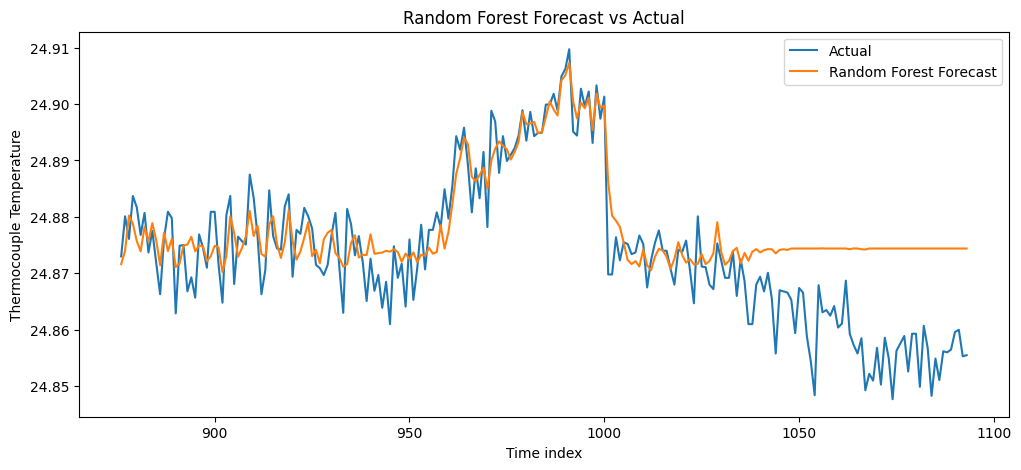

In [24]:
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_pred, label='Random Forest Forecast')
plt.title('Random Forest Forecast vs Actual')
plt.xlabel('Time index')
plt.ylabel('Thermocouple Temperature')
plt.legend()
plt.show()